# Prévision des séries temporelles

# Description et objectifs du projet

Ce projet vise à développer un modèle de prévision des séries temporelles en utilisant des données météorologiques historiques provenant de l'API Historical Weather d'Open-Meteo. Les données de température pour une période de 4 ans seront récupérées pour une ville spécifiée, puis transformées en une nouvelle série temporelle avec un pas de temps de 3 heures. L'objectif est d'analyser les composantes de cette série temporelle et de comparer les performances de différentes méthodes de prévision, à la fois statistiques (ARIMA, SARIMA, SARIMAX) et basées sur des techniques de régression en machine learning. Les variables exogènes, provenant de la même API, seront également intégrées dans les modèles pour améliorer les prévisions. L'analyse des résidus sera effectuée pour évaluer la qualité des modèles. En résumé, ce projet cherche à fournir un modèle robuste et précis pour la prévision de la température basé sur des données historiques et des méthodes avancées d'analyse et de modélisation de séries temporelles.

In [1]:
pip install openmeteo-requests

  Using cached charset_normalizer-3.4.2-cp312-cp312-win_amd64.whl.metadata (36 kB)
   ---------------------------------------- 0.0/165.1 kB ? eta -:--:--
   ---------------------------------------- 165.1/165.1 kB 3.3 MB/s eta 0:00:00
Using cached charset_normalizer-3.4.2-cp312-cp312-win_amd64.whl (105 kB)
   ---------------------------------------- 0.0/669.8 kB ? eta -:--:--
   ----------------------------- --------- 501.8/669.8 kB 10.5 MB/s eta 0:00:01
   ---------------------------------------- 669.8/669.8 kB 7.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/126.1 kB ? eta -:--:--
   ---------------------------------------- 126.1/126.1 kB 7.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/251.9 kB ? eta -:--:--
   --------------------------------------- 251.9/251.9 kB 15.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   -------------- ------------------------- 0.7/2.0 MB 44.8 MB/s eta 0:00:01
   -----------


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install requests-cache retry-requests numpy pandas

  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached typing_extensions-4.14.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached certifi-2025.7.14-py3-none-any.whl.metadata (2.4 kB)
   ---------------------------------------- 0.0/61.4 kB ? eta -:--:--
   ---------------------------------------- 61.4/61.4 kB 3.2 MB/s eta 0:00:00
Using cached attrs-25.3.0-py3-none-any.whl (63 kB)
   ---------------------------------------- 0.0/69.4 kB ? eta -:--:--
   ---------------------------------------- 69.4/69.4 kB 1.9 MB/s eta 0:00:00
Using cached requests-2.32.4-py3-none-any.whl (64 kB)
Using cached urllib3-2.5.0-py3-none-any.whl (129 kB)
Using cached certifi-2025.7.14-py3-none-any.whl (162 kB)
Using cached typing_extensions-4.14.1-py3-none-any.whl (43 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extension


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

ModuleNotFoundError: No module named 'seaborn'

## Load data


In [ ]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 14.6937,
	"longitude": -17.4441,
	"start_date": "2020-01-01",
	"end_date": "2023-12-31",
	"hourly": "temperature_2m"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

Coordinates 14.727592468261719°N -17.4139404296875°E
Elevation 10.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                           date  temperature_2m
0     2020-01-01 00:00:00+00:00       24.984999
1     2020-01-01 01:00:00+00:00       24.984999
2     2020-01-01 02:00:00+00:00       24.834999
3     2020-01-01 03:00:00+00:00       24.535000
4     2020-01-01 04:00:00+00:00       24.135000
...                         ...             ...
35059 2023-12-31 19:00:00+00:00       25.885000
35060 2023-12-31 20:00:00+00:00       25.334999
35061 2023-12-31 21:00:00+00:00       24.984999
35062 2023-12-31 22:00:00+00:00       24.434999
35063 2023-12-31 23:00:00+00:00       24.434999

[35064 rows x 2 columns]


## Exploration and visualisation

In [ ]:
hourly_dataframe.isna().all()

date              False
temperature_2m    False
dtype: bool

In [ ]:
hourly_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   date            35064 non-null  datetime64[ns, UTC]
 1   temperature_2m  35064 non-null  float32            
dtypes: datetime64[ns, UTC](1), float32(1)
memory usage: 411.0 KB


In [ ]:
hourly_dataframe.set_index('date', inplace=True)

In [ ]:
hourly_dataframe.head(10)

,temperature_2m
date,
2020-01-01 00:00:00+00:00,24.984999
2020-01-01 01:00:00+00:00,24.984999
2020-01-01 02:00:00+00:00,24.834999
2020-01-01 03:00:00+00:00,24.535000
2020-01-01 04:00:00+00:00,24.135000
2020-01-01 05:00:00+00:00,23.734999
2020-01-01 06:00:00+00:00,23.334999
2020-01-01 07:00:00+00:00,22.934999
2020-01-01 08:00:00+00:00,22.535000


In [ ]:
# Transformation de la série temporelle
transformed_temperature = hourly_dataframe.resample('3H').mean()

# Afficher les premières lignes de la série transformée
print(transformed_temperature.head())


                           temperature_2m
date                                     
2020-01-01 00:00:00+00:00       24.934998
2020-01-01 03:00:00+00:00       24.135000
2020-01-01 06:00:00+00:00       22.934999
2020-01-01 09:00:00+00:00       23.318335
2020-01-01 12:00:00+00:00       26.268333


In [ ]:
df=transformed_temperature
df.rename(columns={'temperature_2m':'Temperature'},inplace=True)
df

,Temperature
date,
2020-01-01 00:00:00+00:00,24.934998
2020-01-01 03:00:00+00:00,24.135000
2020-01-01 06:00:00+00:00,22.934999
2020-01-01 09:00:00+00:00,23.318335
2020-01-01 12:00:00+00:00,26.268333
...,...
2023-12-31 09:00:00+00:00,25.901667
2023-12-31 12:00:00+00:00,31.318335
2023-12-31 15:00:00+00:00,30.201666


In [ ]:
df['Temperature'] = df['Temperature'].round().astype(int)
df.head()

,Temperature
date,
2020-01-01 00:00:00+00:00,25
2020-01-01 03:00:00+00:00,24
2020-01-01 06:00:00+00:00,23
2020-01-01 09:00:00+00:00,23
2020-01-01 12:00:00+00:00,26


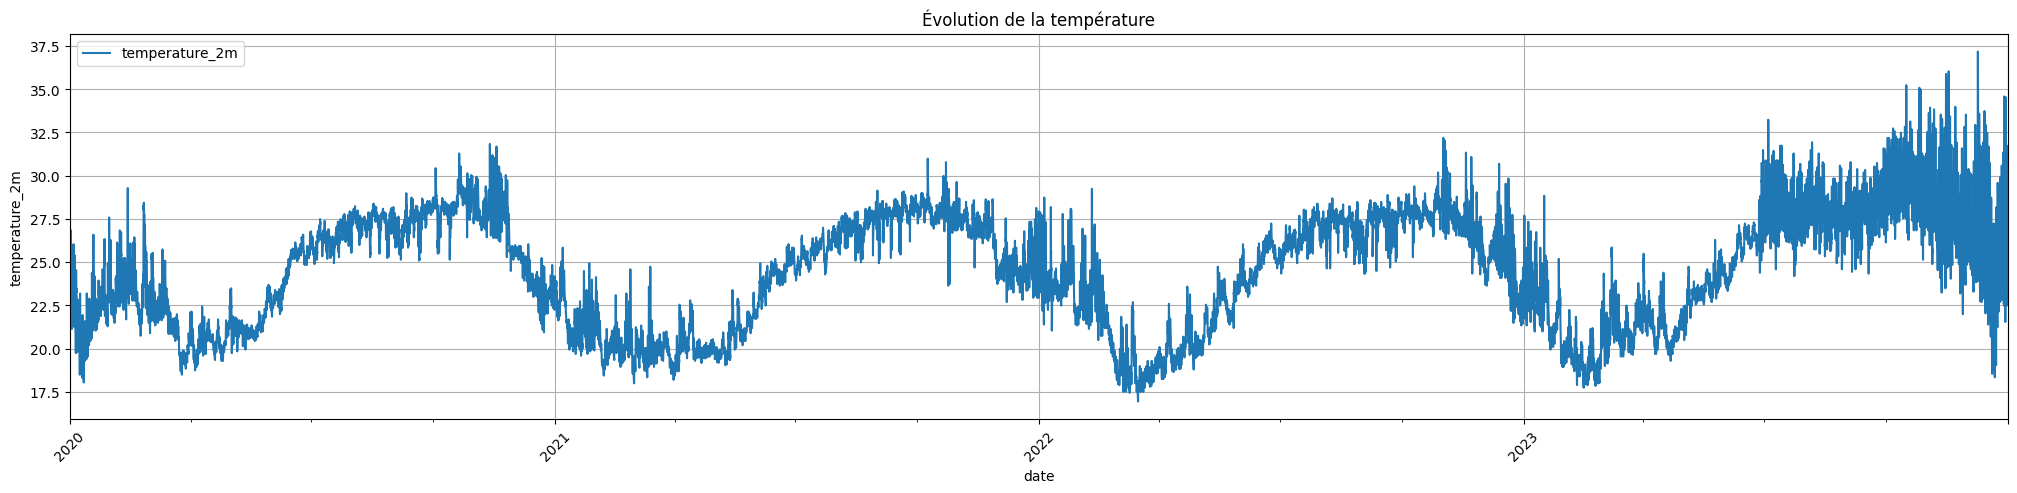

In [ ]:
# Plot chart
import matplotlib.pyplot as plt
hourly_dataframe.plot(y="temperature_2m",figsize=(25,5))
plt.title('Évolution de la température')
plt.xlabel('date')
plt.xticks(rotation=45)  # Fait pivoter les étiquettes de l'axe des x de 45 degrés
plt.ylabel('temperature_2m')
plt.grid(True)
plt.show()
plt.show()

### Autocorrelaction function (ACF)

### Partial Autocorrelation function (PACF)

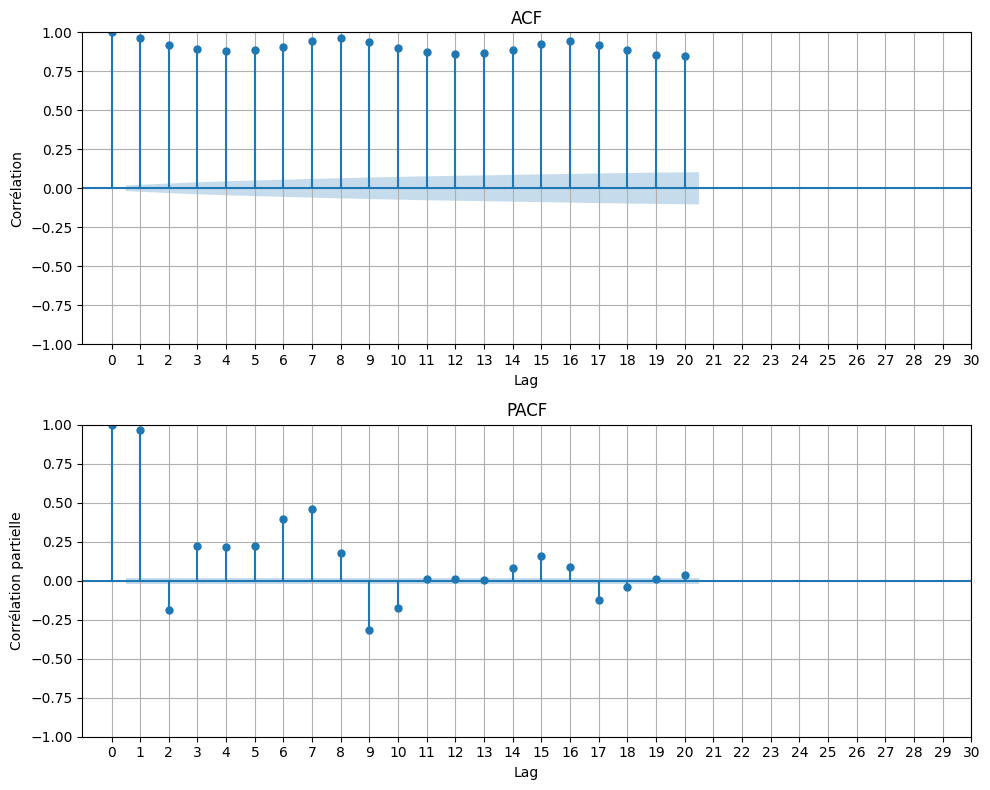

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Créer les subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Tracer l'ACF
plot_acf(df['Temperature'], lags=20, zero=True, ax=ax1)
ax1.set_title('ACF')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Corrélation')
ax1.grid(True)

# Ajuster les graduations sur l'axe x pour l'ACF
ax1.set_xticks(np.arange(0, 31, 1))

# Tracer le PACF
plot_pacf(df['Temperature'], lags=20, zero=True, ax=ax2)
ax2.set_title('PACF')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Corrélation partielle')
ax2.grid(True)

# Ajuster les graduations sur l'axe x pour le PACF
ax2.set_xticks(np.arange(0, 31, 1))

# Ajuster les subplots
plt.tight_layout()

# Afficher le graphique
plt.show()

## Stationarity test

### Augmented Dickey-Fuller test

In [ ]:
# Analyse de la stationnarité de la variable
from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate

# Effectuer le test de Dickey-Fuller augmenté
result = adfuller(df)

# Formater les résultats dans un tableau
table = [
    ['Valeur de test', result[0]],
    ['P-valeur', result[1]],
    ['Conclusion', 'La série est stationnaire' if result[1] < 0.05 else 'La série est non stationnaire']
]

# Afficher les résultats sous forme de tableau
print(tabulate(table, headers=['Métrique', 'Valeur'], tablefmt='github'))

| Métrique       | Valeur                        |
|----------------|-------------------------------|
| Valeur de test | -2.43547474718312             |
| P-valeur       | 0.13197317592355312           |
| Conclusion     | La série est non stationnaire |


### Kwiatkowski-Phillips-Schmidt-Shin test

In [ ]:
from statsmodels.tsa import stattools
# Kwiatkowski–Phillips–Schmidt–Shin test
def check_kpss_stat(ts):

  kpss_results = stattools.kpss(ts)
  kpss_stat = kpss_results[0]
  p_value = kpss_results[1]
  critical_values = kpss_results[3]

  print(f'The KPSS test results\
        \n  test statistic {kpss_stat:.3f},\
        \n  p-value: {p_value:.3f}\
        \n  critical values: {critical_values}')

  if (p_value > 0.05) or (kpss_stat < critical_values['5%']):
      print('The time series is stationary')
  else:
      print('The time series is NOT stationary')

warnings.filterwarnings('ignore')
check_kpss_stat(df)

The KPSS test results        
  test statistic 1.284,        
  p-value: 0.010        
  critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The time series is NOT stationary


## Analyse des composantes de la série temporelle

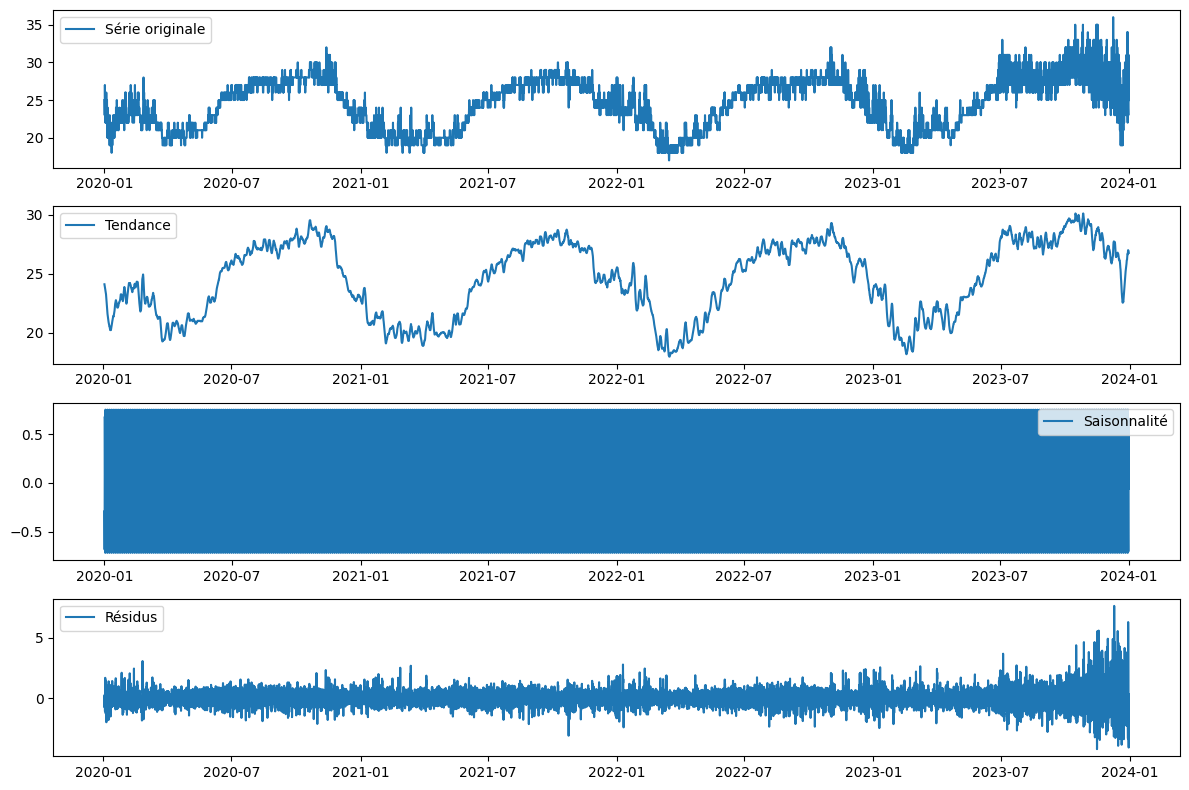

In [ ]:
# Effectuer la décomposition saisonnière
decomposition = seasonal_decompose(df['Temperature'], model='additive')

# Extraire les composantes de la décomposition
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Afficher les composantes de la décomposition
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(df['Temperature'], label='Série originale')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendance')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Saisonnalité')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Résidus')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

Série Originale : La série complète montre les variations de température au fil du temps.

Tendance : La tendance indique une évolution générale de la température, qui peut être à la hausse ou à la baisse sur le long terme.

Saisonnalité : La saisonnalité révèle des motifs répétitifs ou des cycles dans les données, souvent liés aux saisons.

Résidus : Les résidus représentent la partie de la série qui ne peut être expliquée ni par la tendance ni par la saisonnalité.

## Différenciation

La série n’est pas stationnaire,Nous la différencions  pour éliminer les tendances et les saisons.

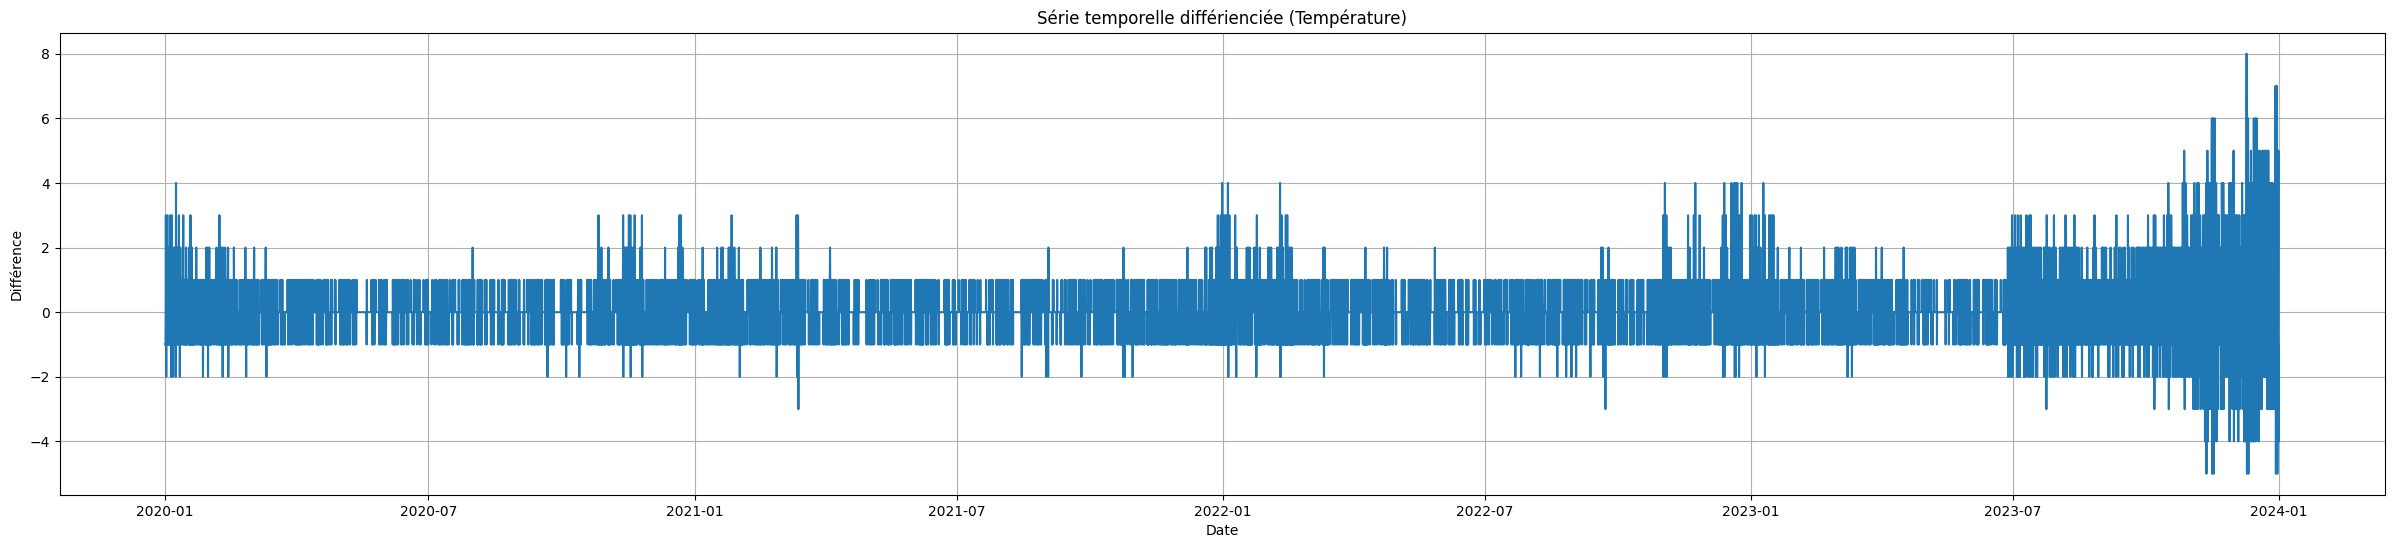

In [ ]:

# Differencing
diff_df = (df - df.shift(1))
# Drop NaN caused by shifting: just the first row in this case
diff_df.dropna(inplace=True)


# Afficher la série différienciée
plt.figure(figsize=(30, 6))
plt.plot(diff_df)
plt.title('Série temporelle différienciée (Température)')
plt.xlabel('Date')
plt.ylabel('Différence')
plt.grid(True)
plt.show()


Après la différenciation, les fluctuations montrent les variations de température au fil du temps sans la tendance générale ni la saisonnalité.

Nous pouvons observer des tendances à court terme qui étaient masquées par la tendance générale et la saisonnalité dans la série originale.

In [ ]:
# Check again stationarity test stats
check_kpss_stat(diff_df)
print("*"*20)
check_kpss_stat(diff_df)

The KPSS test results        
  test statistic 0.021,        
  p-value: 0.100        
  critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The time series is stationary
********************
The KPSS test results        
  test statistic 0.021,        
  p-value: 0.100        
  critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The time series is stationary


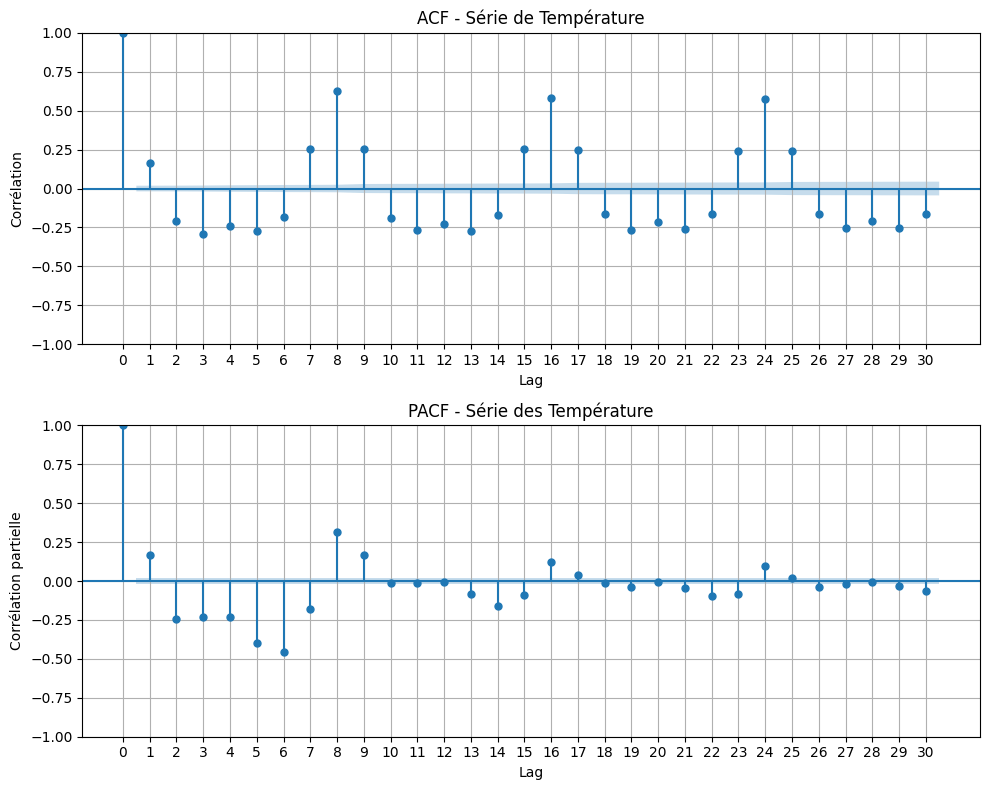

In [ ]:
# Créer les subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Tracer l'ACF
plot_acf(diff_df, lags=30, zero=True, ax=ax1)
ax1.set_title('ACF - Série de Température')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Corrélation')
ax1.grid(True)

# Ajuster les graduations sur l'axe x pour l'ACF
ax1.set_xticks(np.arange(0, 31, 1))

# Tracer le PACF
plot_pacf(diff_df, lags=30, zero=True, ax=ax2)
ax2.set_title('PACF - Série des Température')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Corrélation partielle')
ax2.grid(True)

# Ajuster les graduations sur l'axe x pour le PACF
ax2.set_xticks(np.arange(0, 31, 1))

# Ajuster les subplots
plt.tight_layout()

# Afficher le graphi

on refait les graphiques ACF et PACF pour déterminer les paramètres p,d et q ; il s'agit  d'examiner les barres significatives sur les graphiques

p (AR) : Sur le graphique PACF, identifiez le dernier décalage significatif avant que les barres ne tombent dans la zone de non-significativité. Ce nombre indique l’ordre ( p ) des termes auto-régressifs.

d (I) : Le degré de différenciation ( d ) est le nombre de fois que vous avez dû différencier la série pour la rendre stationnaire.

q (MA) : Sur le graphique ACF, identifiez le dernier décalage significatif avant que les barres ne tombent dans la zone de non-significativité. Ce nombre indique l’ordre ( q ) des termes de moyenne mobile.

## ARIMA

In [ ]:
# Séparer les données en ensemble d'entraînement et ensemble de test
train_data = df['Temperature'][:-15]
test_data = df['Temperature'][-15:]
df.shape, train_data.shape, test_data.shape

((11688, 1), (11673,), (15,))

In [ ]:
p=1
d=1
q=1,3

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Créer un modèle ARIMA(2,1,1)
model = ARIMA(train_data, order=(p,d,q))

# Ajuster le modèle
model_fit = model.fit()

# Afficher le résumé du modèle
print(model_fit.summary())

                                SARIMAX Results                                
Dep. Variable:             Temperature   No. Observations:                11673
Model:             ARIMA(1, 1, [1, 3])   Log Likelihood              -13569.211
Date:                 Sun, 07 Apr 2024   AIC                          27146.423
Time:                         09:16:53   BIC                          27175.883
Sample:                     01-01-2020   HQIC                         27156.319
                          - 12-30-2023                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4002      0.013     30.009      0.000       0.374       0.426
ma.L1         -0.5826      0.012    -50.151      0.000      -0.605      -0.560
ma.L3         -0.3071      0.008    -38.034 

<Figure size 1000x500 with 0 Axes>

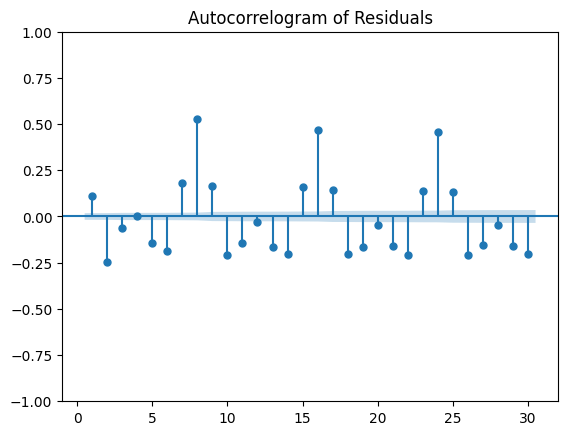

<Figure size 1000x500 with 0 Axes>

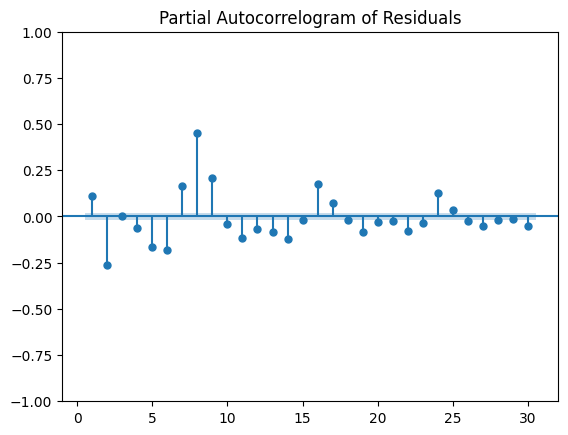

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import seaborn as sns

# Calculer les résidus
residuals = model_fit.resid

# Tracer l'ACF des résidus
plt.figure(figsize=(10, 5))
plot_acf(residuals, lags=30, zero=False)
plt.title("Autocorrelogram of Residuals")
plt.show()

# Tracer la PACF des résidus
plt.figure(figsize=(10, 5))
plot_pacf(residuals, lags=30, zero=False)
plt.title("Partial Autocorrelogram of Residuals")
plt.show()

L’analyse des résidus d’un modèle ARIMA

Le graphique ACF des résidus permet de voir que la plupart des barres  se situent dans la zone de non-significativité,donc l’absence d’autocorrélation

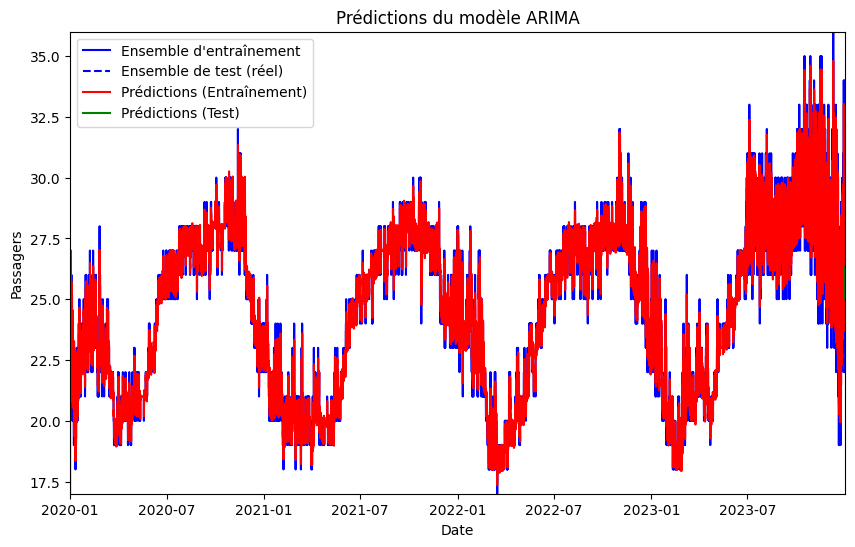

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Prédictions sur l'ensemble d'entraînement
train_predictions = model_fit.predict(start=train_data.index[0], end=train_data.index[-1])

# Prédictions sur l'ensemble de test
test_predictions = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

# Prédictions sur l'ensemble d'entraînement
train_predictions = model_fit.predict(start=train_data.index[0], end=train_data.index[-1])

# Prédictions sur l'ensemble de test
test_predictions = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

# Tracer les prédictions et les données réelles avec les courbes collées
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data.values, label='Ensemble d\'entraînement', color='blue')
plt.plot(test_data.index, test_data.values, label='Ensemble de test (réel)', color='blue', linestyle='--')
plt.plot(train_predictions.index, train_predictions, label='Prédictions (Entraînement)', color='red')
plt.plot(test_predictions.index, test_predictions, label='Prédictions (Test)', color='green')

# Définir les limites des axes x et y pour une continuité visuelle
plt.xlim(train_data.index[0], test_data.index[-1])
plt.ylim(min(train_data.min(), test_data.min()), max(train_data.max(), test_data.max()))

plt.xlabel('Date')
plt.ylabel('Passagers')
plt.title('Prédictions du modèle ARIMA')
plt.legend()
plt.show()

In [ ]:
# Mesures de performance sur l'ensemble d'entraînement
train_mae = mean_absolute_error(train_data, train_predictions)
train_mse = mean_squared_error(train_data, train_predictions)
train_rmse = mean_squared_error(train_data, train_predictions, squared=False)
train_r2 = r2_score(train_data, train_predictions)

# Mesures de performance sur l'ensemble de test
test_mae = mean_absolute_error(test_data, test_predictions)
test_mse = mean_squared_error(test_data, test_predictions)
test_rmse = mean_squared_error(test_data, test_predictions, squared=False)
test_r2 = r2_score(test_data, test_predictions)

# Créer un DataFrame pour afficher les mesures de performance
performance_df = pd.DataFrame({
    'Métrique': ['MAE', 'MSE', 'RMSE', 'R²'],
    'Ensemble d\'entraînement': [train_mae, train_mse, train_rmse, train_r2],
    'Ensemble de test': [test_mae, test_mse, test_rmse, test_r2]
})

print(performance_df)

  Métrique  Ensemble d'entraînement  Ensemble de test
0      MAE                 0.494248          2.889380
1      MSE                 0.652399         12.852698
2     RMSE                 0.807712          3.585066
3       R²                 0.939608          0.042431


MAE augmente considérablement sur l’ensemble de test . Cela peut indiquer un overfitting du modèle aux données d’entraînement.
MSE est faible pour l’ensemble d’entraînement mais est beaucoup plus élevée pour l’ensemble de test , ce qui renforce l’idée d’un surajustement.
RMS suit le même schéma que le MAE et le MSE
R² est très élevé pour l’ensemble d’entraînement , indiquant que le modèle explique bien la variance des données d’entraînement. Cependant, le R² est extrêmement bas pour l’ensemble de test, ce qui signifie que le modèle ne parvient pas à expliquer la variance des données de test et pourrait ne pas être généralisable

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.9 MB/s eta 0:00:00


Nous appliquons un modele auto_arima pour challenger sur les paramètres du modèle

In [ ]:
import pmdarima as pm

# Séparer les données en ensemble d'entraînement et ensemble de test
train_data = df['Temperature'][:-15]
test_data = df['Temperature'][-15:]

# Utiliser auto_arima pour trouver le meilleur modèle ARIMA
model = pm.auto_arima(train_data)

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                11673
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -10482.849
Date:                Sun, 07 Apr 2024   AIC                          20981.699
Time:                        09:26:19   BIC                          21040.619
Sample:                    01-01-2020   HQIC                         21001.491
                         - 12-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9157      0.009    106.269      0.000       0.899       0.933
ar.L2         -0.8661      0.010    -84.823      0.000      -0.886      -0.846
ar.L3         -0.0072      0.013     -0.542      0.5

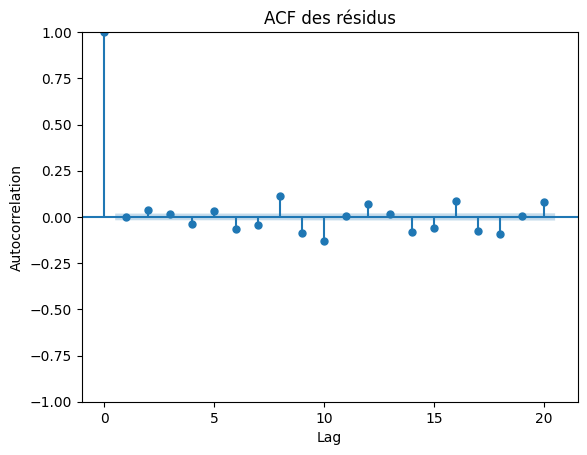

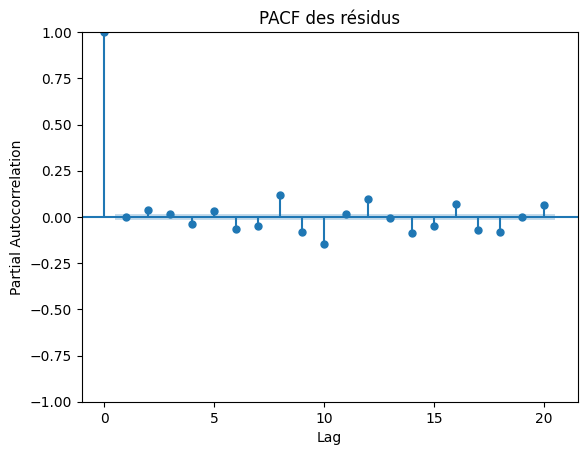

In [ ]:
# Ajuster le modèle aux données
model.fit(train_data)
# Obtenir les résidus du modèle
residuals = model.resid()

# Tracer la fonction d'autocorrélation (ACF) des résidus
plot_acf(residuals, lags=20)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF des résidus')
plt.show()

# Tracer la fonction d'autocorrélation partielle (PACF) des résidus
plot_pacf(residuals, lags=20)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('PACF des résidus')
plt.show()

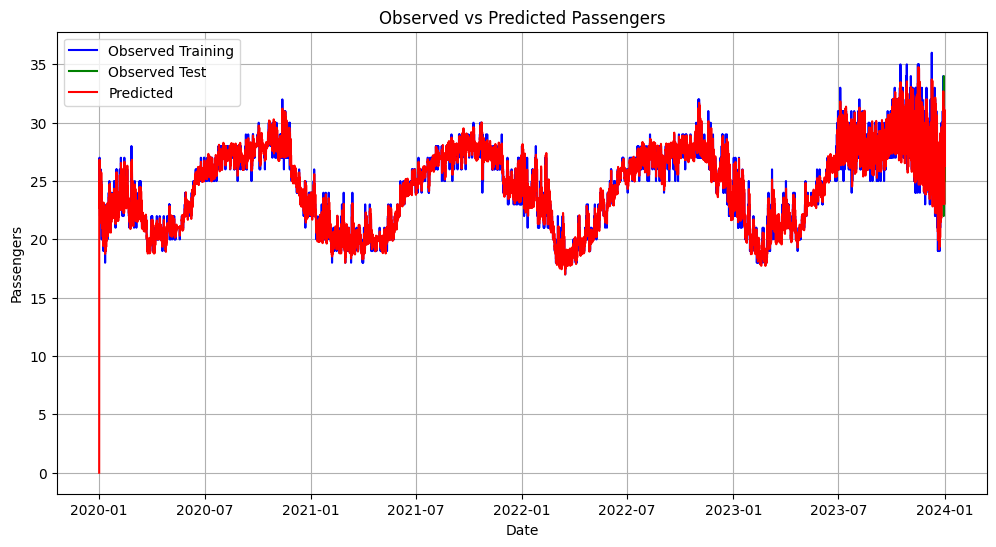

In [ ]:
# Faire des prédictions sur l'ensemble d'entraînement
train_pred, train_confint = model.predict_in_sample(return_conf_int=True)

# Faire des prédictions sur l'ensemble de test
n_periods = len(test_data)
predicted, confint = model.predict(n_periods=n_periods, return_conf_int=True)

# Concaténer les prédictions pour l'ensemble d'entraînement et de test
all_predictions = pd.concat([pd.Series(train_pred, index=train_data.index),
                             pd.Series(predicted, index=test_data.index)],
                            axis=0)

# Tracer les valeurs réelles et les prédictions pour l'ensemble d'entraînement et de test
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Observed Training', color='blue')
plt.plot(test_data, label='Observed Test', color='green')
plt.plot(all_predictions, label='Predicted', color='red')

plt.xlabel('Date')
plt.ylabel('Passengers')
plt.title('Observed vs Predicted Passengers')
plt.legend()
plt.grid(True)
plt.show()

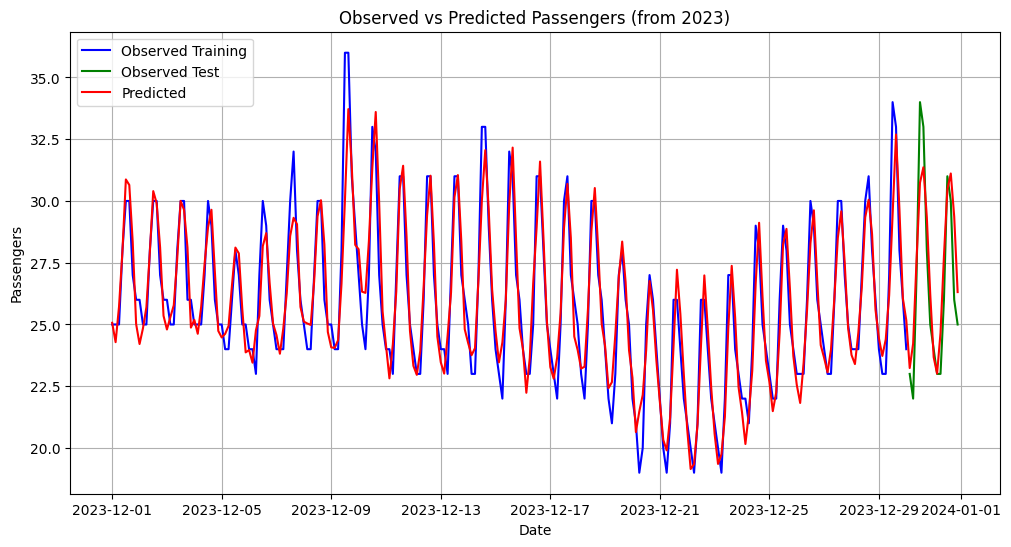

In [ ]:
# Définir la date de départ pour les prédictions
start_date = '2023-12-01'

# Séparer les données d'entraînement et de test à partir de la date de départ
train_data_from_2023 = train_data[start_date:]
test_data_from_2023 = test_data[start_date:]

# Séparer les prédictions à partir de la date de départ
all_predictions_from_2023 = all_predictions[start_date:]

# Tracer les valeurs réelles et les prédictions pour l'ensemble d'entraînement et de test à partir de 2023
plt.figure(figsize=(12, 6))
plt.plot(train_data_from_2023, label='Observed Training', color='blue')
plt.plot(test_data_from_2023, label='Observed Test', color='green')
plt.plot(all_predictions_from_2023, label='Predicted', color='red')

plt.xlabel('Date')
plt.ylabel('Passengers')
plt.title('Observed vs Predicted Passengers (from 2023)')
plt.legend()
plt.grid(True)
plt.show()


auto_arima est une méthode de prévision automatique qui sélectionne le meilleur modèle ARIMA pour les données de séries temporelles. La proximité de la ligne de prédiction avec les données réelles suggère que le modèle a bien capturé la tendance et la saisonnalité des données, ce qui est essentiel pour des prévisions précises

## SARIMAX(p,d,q,P,D,Q,s)

In [ ]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 14.6937,
	"longitude": -17.4441,
	"start_date": "2020-01-01",
	"end_date": "2023-12-31",
	"hourly": ["temperature_2m", "relative_humidity_2m"]
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

Coordinates 14.727592468261719°N -17.4139404296875°E
Elevation 10.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                           date  temperature_2m  relative_humidity_2m
0     2020-01-01 00:00:00+00:00       24.984999             62.330299
1     2020-01-01 01:00:00+00:00       24.984999             47.279957
2     2020-01-01 02:00:00+00:00       24.834999             41.402630
3     2020-01-01 03:00:00+00:00       24.535000             39.695801
4     2020-01-01 04:00:00+00:00       24.135000             37.633198
...                         ...             ...                   ...
35059 2023-12-31 19:00:00+00:00       25.885000             52.351578
35060 2023-12-31 20:00:00+00:00       25.334999             52.886383
35061 2023-12-31 21:00:00+00:00       24.984999             54.000259
35062 2023-12-31 22:00:00+00:00       24.434999             59.117954
35063 2023-12-31 23:00:00+00:00       24.434999             53.168968

[35064 rows x 3 columns]


In [ ]:
hourly_dataframe.set_index('date', inplace=True)
# Transformation de la série temporelle
transformed_temperature = hourly_dataframe.resample('3H').mean()
df=transformed_temperature
df.rename(columns={'temperature_2m':'Temperature','relative_humidity_2m':'humidity'},inplace=True)
df

,Temperature,humidity
date,,
2020-01-01 00:00:00+00:00,24.934998,50.337627
2020-01-01 03:00:00+00:00,24.135000,37.824360
2020-01-01 06:00:00+00:00,22.934999,34.904888
2020-01-01 09:00:00+00:00,23.318335,31.729166
2020-01-01 12:00:00+00:00,26.268333,37.828617
...,...,...
2023-12-31 09:00:00+00:00,25.901667,21.622726
2023-12-31 12:00:00+00:00,31.318335,16.430578
2023-12-31 15:00:00+00:00,30.201666,28.358393


In [ ]:
df['Temperature'] = df['Temperature'].round().astype(int)
df['humidity'] = df['humidity'].round().astype(int)
df.head()

,Temperature,humidity
date,,
2020-01-01 00:00:00+00:00,25,50
2020-01-01 03:00:00+00:00,24,38
2020-01-01 06:00:00+00:00,23,35
2020-01-01 09:00:00+00:00,23,32
2020-01-01 12:00:00+00:00,26,38


### Turing des hypermaramètres

In [ ]:
# Séparer les données en ensemble d'entraînement et ensemble de test
train_data = df['Temperature'][:-15]
test_data = df['Temperature'][-15:]
df.shape, train_data.shape, test_data.shape

((11688, 2), (11673,), (15,))

In [ ]:
order = [(1, 1, 1), (1, 2, 1)]
seasonal_order = [(1, 1, 1, 12), (1, 2, 1, 12)]

s est la période de la saisonnalité. Par exemple, si les données sont mensuelles et présentent une tendance annuelle, s égale 12.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA model
sarima_model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

# Make predictions
sarima_predictions = sarima_result.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

# Définir les hyperparamètres à tuner
p_values = range(0, 12)  # Ordre de l'autorégression
d_values = range(0, 2)  # Ordre de la différenciation
q_values = range(0, 12)  # Ordre de la moyenne mobile

best_order_aic_score, best_order_aic_cfg = float("inf"), None

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                model = SARIMAX(train_data, order=order).fit()
                if model.aic < best_order_aic_score:
                    best_order_aic_score, best_order_aic_cfg = model.aic, order
                    print(f'SARIMAX{order} AIC={model.aic:.3f}')
            except Exception as e:
                print(f"Error encountered for order {order}: {e}")
                continue

print(f'Best SARIMAX{best_order_aic_cfg} AIC={best_order_aic_score:.3f}')


SARIMAX(0, 0, 0) AIC=108018.625
SARIMAX(0, 0, 1) AIC=92434.669
SARIMAX(0, 0, 2) AIC=78588.961
SARIMAX(0, 0, 3) AIC=68800.215
SARIMAX(0, 0, 4) AIC=59852.489
SARIMAX(0, 0, 5) AIC=56762.131
SARIMAX(0, 0, 6) AIC=50204.089
SARIMAX(0, 0, 7) AIC=46317.077
SARIMAX(0, 0, 8) AIC=44042.358
SARIMAX(0, 0, 9) AIC=41783.310
SARIMAX(0, 0, 11) AIC=40597.435
SARIMAX(0, 1, 0) AIC=29248.490
SARIMAX(0, 1, 1) AIC=28790.724
SARIMAX(0, 1, 2) AIC=27459.974
SARIMAX(0, 1, 3) AIC=26062.038
SARIMAX(0, 1, 4) AIC=25929.260
SARIMAX(0, 1, 5) AIC=25738.269
SARIMAX(0, 1, 6) AIC=25480.030
SARIMAX(0, 1, 8) AIC=24128.811
SARIMAX(0, 1, 9) AIC=24108.266
SARIMAX(0, 1, 10) AIC=23242.700
SARIMAX(0, 1, 11) AIC=22961.673
SARIMAX(1, 1, 11) AIC=22957.619
SARIMAX(2, 1, 3) AIC=22599.789
SARIMAX(2, 1, 4) AIC=21615.860
SARIMAX(2, 1, 5) AIC=21601.438
SARIMAX(2, 1, 6) AIC=21425.188
SARIMAX(2, 1, 7) AIC=21369.662
SARIMAX(2, 1, 8) AIC=21214.031
SARIMAX(2, 1, 10) AIC=20784.260
SARIMAX(2, 1, 11) AIC=20677.502
SARIMAX(3, 0, 11) AIC=20655.429


In [ ]:
# Définir les hyperparamètres à tuner
p_values = range(0, 12)  # Ordre de l'autorégression
d_values = range(0, 2)  # Ordre de la différenciation
q_values = range(0, 12)  # Ordre de la moyenne mobile

from statsmodels.tsa.arima.model import ARIMA
best_order_aic_score, best_order_aic_cfg = float("inf"), None

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                model = ARIMA(train_data, order=order).fit()
                if model.aic < best_order_aic_score:
                    best_order_aic_score, best_order_aic_cfg = model.aic, order
                    print(f'ARIMA{order} AIC={model.aic:.3f}')
            except Exception as e:
                print(f"Error encountered for order {order}: {e}")
                continue

print(f'Best ARIMA{best_order_aic_cfg} AIC={best_order_aic_score:.3f}')

ARIMA(0, 0, 0) AIC=60909.890
ARIMA(0, 0, 1) AIC=48089.078
ARIMA(0, 0, 2) AIC=40218.534
ARIMA(0, 0, 3) AIC=35474.087
ARIMA(0, 0, 4) AIC=34150.679
ARIMA(0, 0, 5) AIC=31375.126
ARIMA(0, 0, 6) AIC=29602.727
ARIMA(0, 0, 7) AIC=29535.381
ARIMA(0, 0, 8) AIC=29504.939
ARIMA(0, 0, 9) AIC=29213.161
ARIMA(0, 0, 10) AIC=27608.749
ARIMA(0, 0, 11) AIC=26971.607
ARIMA(0, 1, 3) AIC=26062.038
ARIMA(0, 1, 4) AIC=25929.260
ARIMA(0, 1, 5) AIC=25738.269
ARIMA(0, 1, 6) AIC=25480.030
ARIMA(0, 1, 8) AIC=24128.811
ARIMA(0, 1, 9) AIC=24108.266
ARIMA(0, 1, 10) AIC=23242.700
ARIMA(0, 1, 11) AIC=22961.673
ARIMA(1, 1, 11) AIC=22957.619
ARIMA(2, 1, 3) AIC=22599.789
ARIMA(2, 1, 4) AIC=21615.860
ARIMA(2, 1, 5) AIC=21601.438
ARIMA(2, 1, 6) AIC=21425.188
ARIMA(2, 1, 7) AIC=21369.662
ARIMA(2, 1, 8) AIC=21214.031
ARIMA(2, 1, 10) AIC=20784.260
ARIMA(2, 1, 11) AIC=20677.502
ARIMA(3, 0, 11) AIC=20661.645
ARIMA(4, 1, 4) AIC=20459.955
ARIMA(4, 1, 5) AIC=19259.144
ARIMA(4, 1, 7) AIC=19176.865
ARIMA(4, 1, 10) AIC=19160.143
ARIMA

KeyboardInterrupt: 

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import itertools

# Définir les hyperparamètres à tuner
p_values = range(0, 12)  # Ordre de l'autorégression
d_values = range(0, 2)  # Ordre de la différenciation
q_values = range(0, 12)  # Ordre de la moyenne mobile


best_order_rmse_score, best_order_rmse_cfg = float("inf"), None

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                model = SARIMAX(train_data, order=order).fit()
                ts_pred = model.predict(start=test_data.index[0], end=test_data.index[-1])
                rmse = mean_squared_error(test_data.values, ts_pred.values, squared=False)

                if rmse < best_order_rmse_score:
                    best_order_rmse_score, best_order_rmse_cfg = rmse, order
                    print(f'SARIMAX{order} RMSE={rmse:.3f}')
            except Exception as e:
                print(f"Error encountered for order {order}: {e}")
                continue

print(f'Best SARIMAX{best_order_rmse_cfg} RMSE={best_order_rmse_score:.3f}')


SARIMAX(0, 0, 0) RMSE=26.917
SARIMAX(0, 0, 1) RMSE=26.484
SARIMAX(0, 0, 2) RMSE=25.967
SARIMAX(0, 0, 3) RMSE=25.884
SARIMAX(0, 0, 5) RMSE=24.126
SARIMAX(0, 0, 6) RMSE=23.939
SARIMAX(0, 0, 7) RMSE=23.069
SARIMAX(0, 0, 8) RMSE=21.719
SARIMAX(0, 0, 9) RMSE=19.378
SARIMAX(0, 0, 10) RMSE=18.439
SARIMAX(0, 1, 0) RMSE=4.531
SARIMAX(0, 1, 2) RMSE=3.581
SARIMAX(0, 1, 3) RMSE=3.511
SARIMAX(0, 1, 5) RMSE=3.477
SARIMAX(0, 1, 6) RMSE=3.470
SARIMAX(0, 1, 7) RMSE=3.095
SARIMAX(0, 1, 8) RMSE=2.859
SARIMAX(0, 1, 9) RMSE=2.849
SARIMAX(0, 1, 10) RMSE=2.800
SARIMAX(0, 1, 11) RMSE=2.640
SARIMAX(1, 1, 11) RMSE=2.624
SARIMAX(2, 1, 2) RMSE=2.465
SARIMAX(2, 1, 3) RMSE=1.910
SARIMAX(2, 1, 5) RMSE=1.906
SARIMAX(2, 1, 7) RMSE=1.835
SARIMAX(2, 1, 8) RMSE=1.795
SARIMAX(2, 1, 9) RMSE=1.790
SARIMAX(2, 1, 10) RMSE=1.700
SARIMAX(2, 1, 11) RMSE=1.673
SARIMAX(3, 0, 11) RMSE=1.656
SARIMAX(4, 1, 4) RMSE=1.196
SARIMAX(5, 1, 5) RMSE=1.151
SARIMAX(7, 0, 7) RMSE=1.129


KeyboardInterrupt: 

In [ ]:
# Définir les hyperparamètres à tuner
p = range(0, 3)  # Ordre de l'autorégression
d = range(0, 2)  # Ordre de la différenciation
q = range(0, 3)  # Ordre de la moyenne mobile
P = range(0, 2)  # Ordre de l'autorégression saisonnière
D = range(0, 2)  # Ordre de la différenciation saisonnière
Q = range(0, 2)  # Ordre de la moyenne mobile saisonnière
s = 12  # Période saisonnière

# Générer toutes les combinaisons possibles d'hyperparamètres
param_seasonal_grid = list(itertools.product(P, D, Q, [s]))

best_aic = float('inf')
best_sarimax_model = None

# Recherche sur grille des meilleurs hyperparamètres
for param_seasonal in param_seasonal_grid:
    for param in param_grid:
        try:
            model = SARIMAX(df['temperature'], exog=df['humidity'], order=param, seasonal_order=param_seasonal)
            result = model.fit()
            if result.aic < best_aic:
                best_aic = result.aic
                best_sarimax_model = result
        except:
            continue

print("Meilleurs paramètres SARIMAX:", best_sarimax_model.order, best_sarimax_model.seasonal_order)
print("AIC:", best_aic)


In [ ]:
# Récupérer les résidus des modèles ARIMA, SARIMA et SARIMAX
residuals_arima = best_arima_model.resid
residuals_sarima = best_sarima_model.resid
residuals_sarimax = best_sarimax_model.resid

# Afficher les résidus
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(residuals_arima)
plt.title('Residus ARIMA')
plt.xlabel('Date')
plt.ylabel('Residus')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(residuals_sarima)
plt.title('Residus SARIMA')
plt.xlabel('Date')
plt.ylabel('Residus')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(residuals_sarimax)
plt.title('Residus SARIMAX')
plt.xlabel('Date')
plt.ylabel('Residus')
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import statsmodels.api as sm

# Sélectionner les variables endogène et exogène
endog = df['Temperature']
exog = df['humidity']

# Diviser les données en ensembles d'entraînement et de test
train_endog = endog.iloc[:len(train_data)]
train_exog = exog.iloc[:len(train_data)]
test_endog = endog.iloc[len(train_data):]
test_exog = exog.iloc[len(train_data):]


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Créer le modèle SARIMAX
model = SARIMAX(endog, exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

# Ajuster le modèle
results = model.fit()

# Faire des prédictions
# Utilisez l'exogène sur la période de prédiction
predictions = results.predict()


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pmdarima import auto_arima
# SARIMAX
model = SARIMAX(df['Temperature'], exog=df['humidity'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# Tuning des hyperparamètres sur la grille
model = auto_arima(df['Temperature'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True, stepwise=True)
print(model.summary())

## Expérimentations avec les méthodes ML de régression

In [ ]:
# Créer des variables retardées (lag)
lags = range(1, 6)  # Nombre de retards à tester

for lag in lags:
    df[f'temperature_lag_{lag}'] = df['temperature'].shift(lag)

# Supprimer les lignes avec des valeurs manquantes résultant de la création de variables retardées
df.dropna(inplace=True)

# Diviser les données en variables explicatives (X) et cible (y)
X = df[[f'temperature_lag_{lag}' for lag in lags]]
y = df['temperature']

# Entraîner un modèle de régression linéaire
model_lr = LinearRegression()
model_lr.fit(X, y)

# Afficher les coefficients des variables retardées
print("Coefficients des variables retardées:")
for lag, coef in zip(lags, model_lr.coef_):
    print(f"Temperature Lag {lag}: {coef}")

# Évaluer le modèle
score = model_lr.score(X, y)
print("Score R^2 du modèle de régression linéaire:", score)


In [ ]:
# Créer des variables agrégées
df['temperature_mean'] = df['temperature'].rolling(window=5).mean()
df['temperature_std'] = df['temperature'].rolling(window=5).std()

# Supprimer les lignes avec des valeurs manquantes résultant de la création de variables agrégées
df.dropna(inplace=True)

# Diviser les données en variables explicatives (X) et cible (y)
X = df[['temperature_mean', 'temperature_std']]
y = df['temperature']

# Entraîner un modèle de régression linéaire
model_lr_agg = LinearRegression()
model_lr_agg.fit(X, y)

# Afficher les coefficients des variables agrégées
print("Coefficients des variables agrégées:")
print("Temperature Mean:", model_lr_agg.coef_[0])
print("Temperature Std:", model_lr_agg.coef_[1])

# Évaluer le modèle
score_agg = model_lr_agg.score(X, y)
print("Score R^2 du modèle de régression linéaire avec variables agrégées:", score_agg)


In [ ]:
# Utiliser une variable exogène (ex: 'exog_var')
# Supposons que 'exog_var' est déjà présente dans le DataFrame

# Diviser les données en variables explicatives (X) et cible (y)
X = df[['exog_var']]
y = df['temperature']

# Entraîner un modèle de régression linéaire
model_lr_exog = LinearRegression()
model_lr_exog.fit(X, y)

# Afficher le coefficient de la variable exogène
print("Coefficient de la variable exogène:")
print("Exog Var:", model_lr_exog.coef_[0])

# Évaluer le modèle
score_exog = model_lr_exog.score(X, y)
print("Score R^2 du modèle de régression linéaire avec variable exogène:", score_exog)


In [ ]:
# Définir la date de départ pour les prédictions
start_date = '2023-12-01'

# Séparer les données d'entraînement et de test à partir de la date de départ
train_data_from_2023 = train_data[start_date:]
test_data_from_2023 = test_data[start_date:]

# Séparer les prédictions à partir de la date de départ
all_predictions_from_2023 = all_predictions[start_date:]

# Tracer les valeurs réelles et les prédictions pour l'ensemble d'entraînement et de test à partir de 2023
plt.figure(figsize=(12, 6))
plt.plot(train_data_from_2023, label='Observed Training', color='blue')
plt.plot(test_data_from_2023, label='Observed Test', color='green')
plt.plot(all_predictions_from_2023, label='Predicted', color='red')

plt.xlabel('Date')
plt.ylabel('Passengers')
plt.title('Observed vs Predicted Passengers (from 2023)')
plt.legend()
plt.grid(True)
plt.show()
